In [17]:
import stim
import sys
import os
sys.path.append(os.path.abspath("../src"))
from bb_ions import *

# Clear last example circuits and remake directories:
empty_folder('example_circuits')
empty_folder('example_circuit_diagrams')

# Define code:

# [[30, 4, 5]] BB5 (weight-5 stabilisers) code from Ye Delfosse long chain [2503.22071] Table II
l = 5
m = 3
# A = x^0 + x
# B = x^0 + y + x^2*y^2
Aij = [(0, 0), (1, 0)]  # the powers (i, j) of each x^i * y^j in A
Bij = [(0, 0), (0, 1), (2, 2)]

code = get_code_params(l, m, Aij, Bij)


# Generate circuits:

ps = [0.001, 0.002] # physical error rate values
memory_basis = 'Z'
num_rounds = code.d_max

for p in ps:

    circuit = make_BB_circuit(  # see src/bb_ions/circfuncs for explanation of make_BB_circuit inputs
        code,  
        p,  
        errors = tham_modules_errors(p),
        idle_during = tham_modules_idle_errors(p),
        num_syndrome_extraction_cycles = num_rounds,  
        memory_basis = 'Z',
        sequential_gates = True, 
        exclude_opposite_basis_detectors = True,
        reuse_check_qubits = True,  
    )

    # Save circuit and diagram:
    filename = f"nkd=[[{code.n}_{code.k}_{code.d_max}]],p={p},b={memory_basis},r={num_rounds},l={l},m={m},A='{''.join(str(x) + str(y) for x, y in Aij)}',B='{''.join(str(x) + str(y) for x, y in Bij)}'"
    circuit.to_file(f"example_circuits/{filename}.stim")
    
    #  svg = str(circuit.diagram("timeline-svg"))
    # with open(f"example_circuit_diagrams/{filename}.svg", "w", encoding="utf-8") as f: f.write(svg)

In [18]:
# # Run memory experiment simulations:

import sinter
import glob
from stimbposd import SinterDecoder_BPOSD, sinter_decoders

circuit_paths = glob.glob(f"example_circuits/nkd=[[{code.n}_{code.k}_{code.d_max}*.stim")

csv_path = "example_stats/collected_stats.csv"

tasks = [
    sinter.Task(
        circuit_path = path,
        json_metadata = sinter.comma_separated_key_values(path),
    )
    for path in circuit_paths
]


empty_folder('example_stats') # clear previous example stats

# Collect new stats:
samples = sinter.collect(
    num_workers=4,
    max_shots=10000,
    max_errors=100,
    tasks = tasks,
    decoders=['bposd'],
    save_resume_filepath = csv_path,
    custom_decoders = {
        "bposd": SinterDecoder_BPOSD(
            # max_bp_iters = 30, # default is 30
            # bp_method="minimum_sum", # product_sum (default), min_sum, min_sum_log
            # ms_scaling_factor = 0.625, # normalisation
            # schedule="serial",
            # osd_method="osd_cs", # "osd0" - zero-order, "osd_e" - exhaustive, "osd_cs": combination-sweep (default)
            # osd_order=9  # default is 60
        )
    },
    )

Text(0, 0.5, 'Logical Error Rate per round')

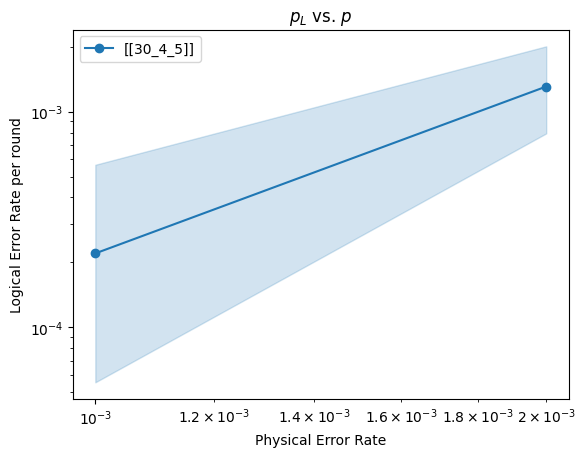

In [ ]:
# Plot results:

import matplotlib.pyplot as plt

# Plot:
collected_stats = sinter.stats_from_csv_files(f'example_stats/collected_stats.csv')

fig, ax = plt.subplots(1, 1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
)

ax.loglog()
ax.legend()
ax.set_title("$p_L$ vs. $p$")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per round");